# Black Friday--Cluster

## dataset description

"Dataset of 550 000 observations about the black Friday in a retail store, it contains different kinds of variables either numerical or categorical. It contains missing values."

## raw data


In [40]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_allData=pd.read_csv('BlackFriday.csv')
print(df_allData.sample(n=5))

        User_ID Product_ID Gender    Age  Occupation City_Category  \
499660  1004950  P00293242      M  26-35          16             A   
41149   1000329  P00131542      M  36-45           7             A   
474225  1001088  P00210342      F   0-17          10             A   
377102  1004021   P0095842      M  51-55          20             B   
446425  1002781  P00184042      M  36-45           4             C   

       Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
499660                          1               1                   8   
41149                           1               0                   8   
474225                          3               0                   3   
377102                          1               1                   3   
446425                          2               1                   1   

        Product_Category_2  Product_Category_3  Purchase  
499660                16.0                 NaN      7857  
41149                 

raw data has 12 columns and there are a lot of missing values in "Product_Category_2" and "Product_Category_3". Which means some of the product whould just have one category.

## data pre-processing


In our opinion, we think our model would do cluster on different people, so our key is people.

But the dataset includes different records of one-single people. So at the beginning we use gruopby to get each people's whole records. 

Then we try to get the mode of each one's "Product_Category_1" to represent the main product category and get the mean of one people's whole "Purchase" as a feature of "average purchase". (We are not sure weather this is a good way buy we have to do this because we cannot keep all the data to train)

What's more, we change the "Gender" attribute to 0-1 attribute.

In [3]:
groupByUserData=df_allData.groupby(['User_ID'])

times=df_allData['User_ID'].value_counts()
times=times.sort_index()

#get the mean
meanData=groupByUserData.mean()

#get the mode
modeData=groupByUserData.agg(lambda x: stats.mode(x)[0][0])

mean_mode_data={'Gender':modeData['Gender'],'Occupation':modeData['Occupation'],'Age':modeData['Age'],'City_Category':modeData['City_Category'],'Marital_Status':modeData['Marital_Status'],'Product_CateGory_1':modeData['Product_Category_1'],'Stay_In_Current_City_Years':modeData['Stay_In_Current_City_Years']}
mean_mode_data=pd.DataFrame(mean_mode_data)
mean_mode_data['times']=times
mean_mode_data['Gender_M']=pd.get_dummies(mean_mode_data['Gender'])['M']
mean_mode_data=mean_mode_data.drop(['Gender'],axis=1)
mean_mode_data['Purchase']=meanData['Purchase']

print (mean_mode_data.sample(5))

O:\Anaconda\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


         Occupation    Age City_Category  Marital_Status  Product_CateGory_1  \
User_ID                                                                        
1005664           4  18-25             C               0                   1   
1003223          20  26-35             A               1                   5   
1000108          12  26-35             C               0                   5   
1001478          10   0-17             C               0                   8   
1000661           1  46-50             C               1                   1   

        Stay_In_Current_City_Years  times  Gender_M      Purchase  
User_ID                                                            
1005664                         4+    141         1  11133.815603  
1003223                          1     32         1  10167.093750  
1000108                          3     14         1   8633.714286  
1001478                          2     16         1   7854.562500  
1000661                        

## feature extraction

This is the hardest part of our cluster project.

There are two key problems we have to face:

##### 1. **how to handle the discrete attributes?**
    
    There are a lot of disordered discrete attributes in our data, likes "Marital_Status", "Gender" and "Product_Category_1", we cannot just simplely calculate their euclidean distance.

##### 2. **how to evaluate our feature extraction performance?**

    Since we have so many choices of extracting the features and we do not know how to assign the weights on these feautres and this is a cluster problem, we had not a clearly mind of have to evaluate our work when we doing the feature extraction. And it is unrealistic to try all the choices and train them then evaluate the final models. The best solution is that we can find some explainable output of our feature extraction.
    
#### deal with discrete attributes

To solve the key problems 1, we came up with ideas.

1. do one-hot encoding on the discrete attributes

1. use k-modes or k-prototype model

1. drop those discrete attributes

But their would raise some new problems if we use these solutions:

    one-hot encoding would make the features very sparse.
    
    It is not easy to combine the VDM distance and Minkowski distance together.
    
    Some discrete features may be very important like occupation but it would have a lot of possible value.
    
#### deal with evaluation

We do not find a good way to solve this problem, we just living with it, but we still did some tries. Likes using the average purchase to evaluate the cluster output. And we use Calinski-Harabasz score and Value Difference Metrix to evalue our final clusters.

## data pre-processing before training

Since we have features of different units, we must do the data standardization and assign different weights to different features.

We choose min-max standardization and assign the weights by feeling.

## specific model 1: k-modes

I try to use the k-modes only on the categorical values to train a model, then use one-hot encoidng data to calculate the jaccard distance and euclidean distance.

In [4]:
from kmodes.kmodes import KModes

ModuleNotFoundError: No module named 'kmodes'

In [ ]:
X=pd.DataFrame({'Gender':modeData['Gender'],'Occupation':modeData['Occupation'],'Age':modeData['Age'],'City_Category':modeData['City_Category'],'Marital_Status':modeData['Marital_Status'],'Product_CateGory_1':modeData['Product_Category_1'],"Stay_In_Current_City_Years":modeData["Stay_In_Current_City_Years"]})

one_hot_city=pd.get_dummies(mean_mode_data['City_Category'])
one_hot_age=pd.get_dummies(mean_mode_data['Age'])
one_hot_occupation=pd.get_dummies(mean_mode_data['Occupation'])
one_hot_years=pd.get_dummies(mean_mode_data['Stay_In_Current_City_Years'])
one_hot_product=pd.get_dummies(mean_mode_data['Product_CateGory_1'])
XX=pd.concat([one_hot_age,one_hot_city,one_hot_occupation,one_hot_years,one_hot_product],axis=1)
XX['Gender_M']=mean_mode_data['Gender_M']
XX['Marital_Status']=mean_mode_data['Marital_Status']

print ("categorical data:")
print(X.sample(2))
print("one-hot encoding data:")
print(XX.sample(2))


In [ ]:
from sklearn.metrics import jaccard_similarity_score

jcArr=[]
for i in range(2,10):
    km=KModes(n_clusters=i)
    y=km.fit_predict(X)
    tempArr=[]
    for j in range(i):
        #print(sum(y==j))
        #print(XX[y==j].mode())
        jcscore=[]
        for k in XX[y==j].T:
            try:
                jcscore.append(jaccard_similarity_score(XX.loc[k],XX[y==j].mode().T[0]))
            except:
                #print(XX.loc[k].T)
                print(XX[y==j].mode())
                hhh=XX[y==j].mode()
                #print(k)
                break;
        #print(np.mean(jcscore))
        tempArr.append(np.mean(jcscore))
    print("n_cluster =",i,":",np.mean(tempArr))
    jcArr.append(np.mean(tempArr))



In [ ]:
ecArr=[]
for i in range(2,10):
    km=KModes(n_clusters=i)
    y=km.fit_predict(X)
    tempArr=[]
    for j in range(i):
        #print(sum(y==j))
        #print(XX[y==j].mode())
        ecscore=[]
        for k in XX[y==j].T:
            if(k):
                ecscore.append(np.linalg.norm(np.array(XX.loc[k])-np.array(XX[y==j].mode().T[0])))
        #print(np.mean(ecscore))
        tempArr.append(np.mean(ecscore))
    print("n_cluster =",i,":",np.mean(tempArr))


In [ ]:
np.linalg.norm(np.array(XX.loc[1004491])-np.array(XX.mode().T))

## specific model 2:

In [34]:
def recenter_regularize(X):
    #X_mean = np.mean(X, axis = 1)[np.newaxis]
    X_mean = np.mean(X)
    X_centered = X - X_mean
    #X_norm = np.linalg.norm(X_centered)[np.newaxis]
    X_norm = np.linalg.norm(X_centered)
    X_normalized = X_centered/X_norm
    return X_normalized

numGroup = 10

print(mean_mode_data['times'])
print(mean_mode_data['Purchase'])
print(np.array(mean_mode_data.times))
times_arr = np.array(mean_mode_data.times)
times_regularized = recenter_regularize(times_arr)
purchases_regularized = recenter_regularize(np.array(mean_mode_data['Purchase']))

ini_index = np.random.choice(a=range(len(times_arr)), size=len(times_arr), replace=False)

X_2d = np.asarray([times_regularized, purchases_regularized]).T
X_2d_group = []
icr = int(np.floor(len(ini_index)/numGroup))
for i in range(numGroup):
    X_2d_group.append(X_2d[i*icr:(i+1)*icr])

isFinished = False
counter = 0
while((not isFinished) and counter <= 200):
    isFinished = True
    numDiff=0
    X_mean_group = [np.mean(X, axis = 0) for X in X_2d_group]
    X_2d_group_new = [[] for h in range(numGroup)]
    for i in range(numGroup):
        
        X_2d_this = X_2d_group[i]
        for j in range(len(X_2d_this)):
            
            sample = X_2d_this[j]
            dist_group = [[] for h in range(numGroup)]
            for k in range(numGroup):
                dist_group[k] = np.linalg.norm(sample - X_mean_group[k])
            
            group = np.argmin(dist_group)
            if(i != group):
                isFinished = False
                numDiff += 1
            X_2d_group_new[group].append(sample)
    X_2d_group = X_2d_group_new
    counter+=1

    

User_ID
1000001     34
1000002     76
1000003     29
1000004     13
1000005    106
1000006     46
1000007     16
1000008     76
1000009     57
1000010    222
1000011     69
1000012     11
1000013     60
1000014     13
1000015    116
1000016     21
1000017    114
1000018    179
1000019    144
1000020     12
1000021     13
1000022    155
1000023    171
1000024     76
1000025     43
1000026    226
1000027     41
1000028     57
1000029     52
1000030     30
          ... 
1006011     99
1006012     15
1006013     72
1006014     54
1006015     32
1006016    469
1006017     15
1006018     76
1006019     44
1006020     23
1006021     64
1006022     24
1006023     77
1006024     55
1006025    142
1006026     42
1006027     22
1006028     26
1006029     14
1006030     53
1006031     30
1006032     51
1006033     35
1006034     11
1006035    143
1006036    476
1006037    116
1006038     10
1006039     67
1006040    169
Name: times, Length: 5891, dtype: int64
User_ID
1000001     9808.264706
10000

In [ ]:
def recenter_regularize(X):
    #X_mean = np.mean(X, axis = 1)[np.newaxis]
    X_mean = np.mean(X)
    X_centered = X - X_mean
    #X_norm = np.linalg.norm(X_centered)[np.newaxis]
    X_norm = np.linalg.norm(X_centered)
    X_normalized = X_centered/X_norm
    return X_normalized

numGroup = 10

print(mean_mode_data['times'])
print(mean_mode_data['Purchase'])
print(np.array(mean_mode_data.times))
times_arr = np.array(mean_mode_data.times)
times_regularized = recenter_regularize(times_arr)
purchases_regularized = recenter_regularize(np.array(mean_mode_data['Purchase']))

ini_index = np.random.choice(a=range(len(times_arr)), size=len(times_arr), replace=False)

X_2d = np.hstack(np.asarray([times_regularized, purchases_regularized])).T
X_2d_group = []
icr = int(np.floor(len(ini_index)/numGroup))
for i in range(numGroup):
    X_2d_group.append(X_2d[i*icr:(i+1)*icr])

isFinished = False
counter = 0
while((not isFinished) and counter <= 200):
    isFinished = True
    numDiff=0
    X_mean_group = [np.mean(X, axis = 0) for X in X_2d_group]
    X_2d_group_new = [[] for h in range(numGroup)]
    for i in range(numGroup):
        
        X_2d_this = X_2d_group[i]
        for j in range(len(X_2d_this)):
            
            sample = X_2d_this[j]
            dist_group = [[] for h in range(numGroup)]
            for k in range(numGroup):
                dist_group[k] = np.linalg.norm(sample - X_mean_group[k])
            
            group = np.argmin(dist_group)
            if(i != group):
                isFinished = False
                numDiff += 1
            X_2d_group_new[group].append(sample)
    X_2d_group = X_2d_group_new
    counter+=1

    

In [37]:
len(X_2d_group[0][0])

2

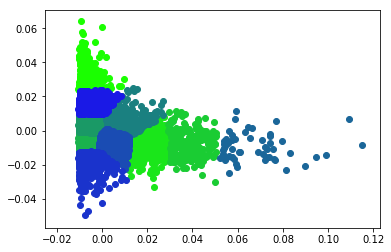

In [46]:
X_2d_group_arr = np.asarray(X_2d_group)
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(numGroup):
    for j in range(len(X_2d_group_arr[i])):
        ax.scatter(X_2d_group_arr[i][j][0], X_2d_group_arr[i][j][1], color = [0.1, 1-0.1*i, 0.1*i])
plt.show()

In [44]:
X_2d_group_arr[0]

[array([-0.00962566,  0.04101193]),
 array([-0.00925664,  0.03298277]),
 array([-0.00974866,  0.03854803]),
 array([-0.00482845,  0.02448442]),
 array([-0.00937965,  0.02902366]),
 array([-0.00310637,  0.02535598]),
 array([-0.00322938,  0.05222155]),
 array([-0.00322938,  0.03965357]),
 array([-0.00630451,  0.04139588]),
 array([-0.00765757,  0.03027249]),
 array([-0.00618151,  0.03063875]),
 array([-0.00679653,  0.02871584]),
 array([-0.00089227,  0.03481157]),
 array([-0.0015073 ,  0.04294878]),
 array([-0.00679653,  0.04523414]),
 array([-0.00937965,  0.02811589]),
 array([-0.00937965,  0.02995117]),
 array([-0.00445943,  0.02772952]),
 array([-0.00741156,  0.02887323]),
 array([-0.00421342,  0.03865092]),
 array([-0.00925664,  0.03448008]),
 array([-0.00913364,  0.0276855 ]),
 array([-0.00445943,  0.03963443]),
 array([-0.00913364,  0.0311708 ]),
 array([-0.00962566,  0.02890484]),
 array([-0.00987167,  0.03572545]),
 array([-0.00642752,  0.03028038]),
 array([-0.00999467,  0.0269

## specific model 3: